### Reading data

In [2]:

import numpy as np
from sclibrary import dataset_loader
from sclibrary import SCPlot
import matplotlib.pyplot as plt

sc, coordinates = dataset_loader.load_paper_data()

# create a plot
scplot = SCPlot(sc, coordinates)

### Chebyshev filter design

In [3]:
from sclibrary.utils.eigendecomposition import get_eigendecomposition

L1 = sc.hodge_laplacian_matrix(rank=1)
L1L = sc.lower_laplacian_matrix(rank=1)

# gradient
U, eigenvals = get_eigendecomposition(L1)
U_l, eigenvals_l = get_eigendecomposition(L1L)

U_H, eigenvals_h = sc.get_eigendecomposition(component="harmonic")
U_G, eigenvals_g = sc.get_eigendecomposition(component="gradient")

In [39]:
f = np.array([
    0.0323,
    0.4980,
    2.3825,
    0.8799,
    -0.5297,
    -0.5192,
    1.0754,
    0.4732,
    -1.1667,
    0.0922
])
#f = np.array([2.90, 0.25, 1.78, -1.50, 1.76, 1.53, 1.32, 0.08, 0.67, 1.73])

In [40]:
f_g = sc.get_hodgedecomposition(flow=f, component="gradient", round_fig=False)
f_g

array([ 0.24764684,  1.34289367,  1.32225949,  1.09524684, -0.02063418,
        0.03197468,  0.52422532, -0.47161646, -0.77305823, -0.30144177])

In [41]:
# approx largest true eigenvalue using power iteration method
# power iteration
v = np.ones(L1L.shape[0])
for i in range(50):
    v = L1L @ v
    v = v / np.linalg.norm(v)

print("v", v)
# mean of the largest eigenvalue
lamda_g_max = np.mean(L1L @ v / v)
print("lamda_g_max", lamda_g_max)

v [ 0.05882426 -0.32941538  0.14631812 -0.38823965  0.4757335   0.49026405
 -0.30516876  0.31969932  0.12266404 -0.19703528]
lamda_g_max 5.4879826825028015


In [90]:
from chebpy import chebfun

# build the continuos subcomponent extraction function

# cut off frequency - gradient
cut_off_freq_g = 0.01
steep = 100

# logistic function to perform gradient component extraction
g_g = lambda lam: 1 / (1 + np.exp(-steep * (lam - cut_off_freq_g)))

# TODO: do for other components
# for curl cmax function
# for gradient, 1 -

g_g_cheb = chebfun(g_g, [0, lamda_g_max], 10)

# filter coefficients of the gradient component
coeffs_g = g_g_cheb.funs[0].coeffs
coeffs_g

array([ 0.95938561,  0.08122877, -0.08122876,  0.08122875, -0.08122874,
        0.08122872, -0.08122871,  0.0812287 , -0.08122869,  0.04061435])

Text(0.5, 1.0, 'Frequency response on the gradient eigenvals vs chebyshev approx')

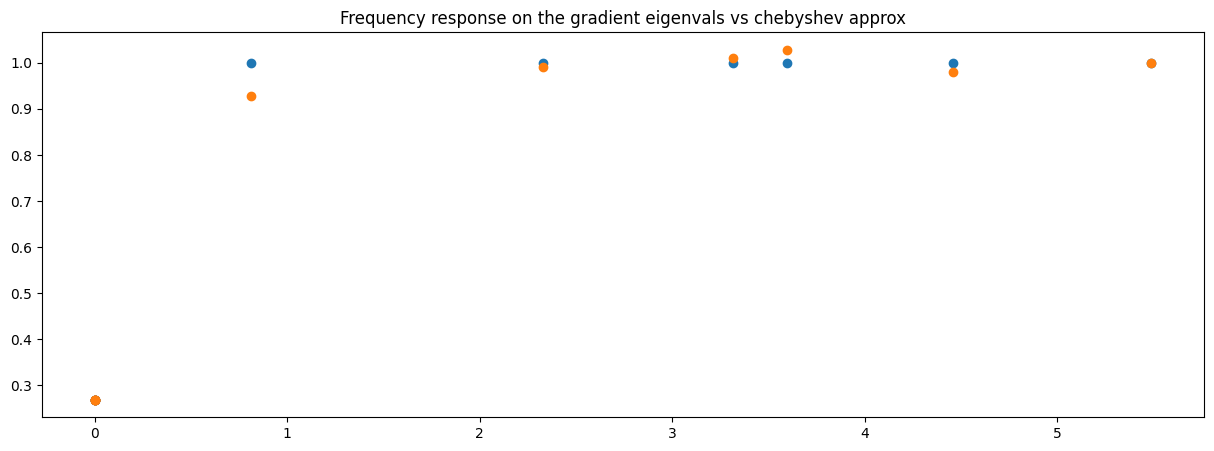

In [91]:
# plot the continuous frequency response 

plt.figure(figsize=(15, 5))
# gradient eigenvalues
plt.scatter(eigenvals_l, g_g(eigenvals_l))
# chebyshev approx
plt.scatter(eigenvals_l, g_g_cheb(eigenvals_l))
plt.title("Frequency response on the gradient eigenvals vs chebyshev approx")

difference 1.913538576985806


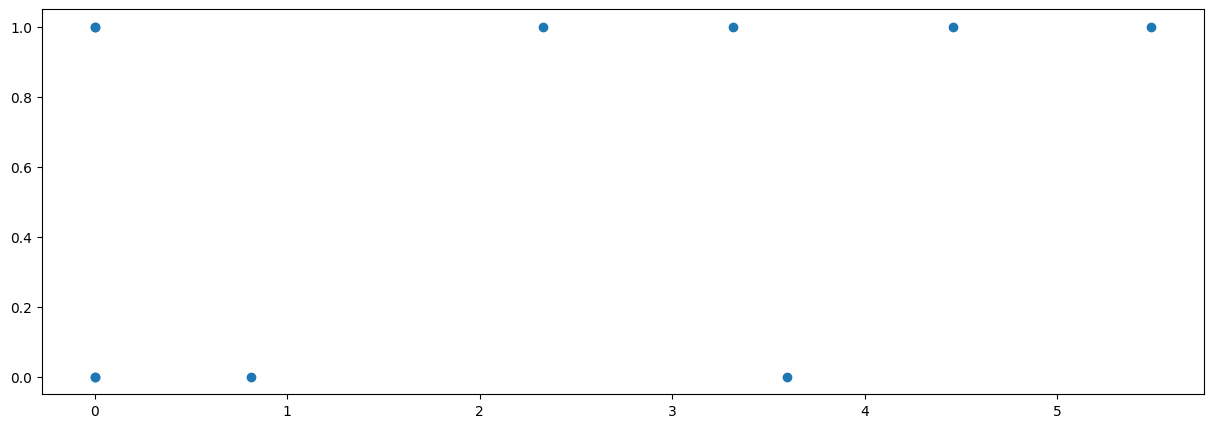

In [92]:

component = "gradient"

# the ideal frequency response
h_g_ideal = sc.get_component_coefficients(component)
H_g_ideal = U_l @ np.diag(h_g_ideal) @ U_l.T
# difference 
print("difference", np.linalg.norm(H_g_ideal - U_G @ U_G.T))

# pplo the ideal frequency response
plt.figure(figsize=(15, 5))
plt.scatter(eigenvals_l, h_g_ideal)

In [93]:
# perform a transformation to shit the domain to [0, lambda_g_max]
alpha_g = lamda_g_max / 2
points = (eigenvals_l - alpha_g) / alpha_g
alpha_g

2.7439913412514008

In [252]:
def chebyshev_filter_approximate(laplacian_matrix, coefficients, alpha, k_trnc):
    coeffs = np.array(coefficients[:k_trnc])
    K = len(coeffs)
    
    I = np.eye(laplacian_matrix.shape[0])
    H_cheb_approx = np.zeros((k_trnc, laplacian_matrix.shape[0], laplacian_matrix.shape[1]))
    
    for k in range(K):
        if k == 0:
            H_cheb_approx[k, :, :] = I
        elif k == 1:
            H_cheb_approx[k, :, :] = 1 / alpha * (laplacian_matrix - alpha * I)
        else:
            H_cheb_approx[k, :, :] = 2 / alpha * (laplacian_matrix - alpha * I) @ H_cheb_approx[k - 1, :, :] - H_cheb_approx[k - 2, :, :]
    
    H_cheb_approx_out = np.sum(coeffs[:, np.newaxis, np.newaxis] * H_cheb_approx, axis=0)
    # multiply coefficients and sum on axis 
    return H_cheb_approx_out

In [206]:
import numpy as np

# truncated order 
K_trunc = 10

H_g_cheb_approx_out = np.zeros((K_trunc, L1L.shape[0], L1L.shape[1]))

for k in range(1, K_trunc + 1):
    H_g_cheb_approx_out[k - 1:, :, :] = chebyshev_filter_approximate(L1L, coeffs_g, alpha_g, k) 

H_g_cheb_approx_out[2:,:,]

array([[[ 9.41919018e-01,  6.17073811e-02,  4.01312113e-02,
         -8.32835509e-02, -2.15761698e-02, -2.02968566e-18,
          2.15761698e-02,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 6.17073811e-02,  8.98766678e-01,  6.17073811e-02,
          4.01312113e-02, -4.01312113e-02, -1.85550415e-02,
         -2.02968566e-18,  2.15761698e-02,  0.00000000e+00,
         -2.15761698e-02],
        [ 4.01312113e-02,  6.17073811e-02,  9.20342848e-01,
          2.15761698e-02,  6.17073811e-02, -2.02968566e-18,
         -4.01312113e-02, -2.15761698e-02, -2.15761698e-02,
          0.00000000e+00],
        [-8.32835509e-02,  4.01312113e-02,  2.15761698e-02,
          9.20342848e-01, -1.85550415e-02, -1.85550415e-02,
         -2.15761698e-02,  2.15761698e-02,  0.00000000e+00,
         -2.15761698e-02],
        [-2.15761698e-02, -4.01312113e-02,  6.17073811e-02,
         -1.85550415e-02,  8.98766678e-01,  1.85550415e-02,
         -4.01312113e-02, -4.31523396e-02, -2.157616

In [116]:
errors_g_response = np.zeros(K_trunc)
errors_filter = np.zeros(K_trunc)

f_g_cheb = np.zeros((L1L.shape[0], K_trunc))
f_g_cheb_tilde = np.zeros((L1L.shape[0], K_trunc))

error_g_tilde = np.zeros(K_trunc)
error_g = np.zeros(K_trunc)


for k in range(K_trunc):
    
    g_g_cheb_approx = np.diag(U_l.T @ np.squeeze(H_g_cheb_approx_out[k, :, :]) @ U_l)
    
    # compute the error with respect to the ideal frequency response
    errors_g_response[k] = np.linalg.norm(g_g_cheb_approx - h_g_ideal) / np.linalg.norm(h_g_ideal)
    errors_filter[k] = np.linalg.norm(np.squeeze(H_g_cheb_approx_out[k, :, :]) - H_g_ideal, 2)
    
    f_g_cheb[:, k] = np.squeeze(H_g_cheb_approx_out[k, :, :]) @ f
    f_g_cheb_tilde[:, k] = U.T @ f_g_cheb[:, k]
    
    error_g_tilde[k] = np.linalg.norm(f_g_cheb_tilde[:, k] - U.T @ f_g) / np.linalg.norm(U.T * f_g)
    error_g[k] = np.linalg.norm(f_g_cheb[:, k] - f_g) / np.linalg.norm(f_g)
    
f_g_cheb[-1]

array([ 0.08845535,  0.05324932, -0.05984449, -0.03937128, -0.00474173,
       -0.05314049, -0.13275172, -0.1043798 , -0.18788527, -0.22529063])

In [117]:
errors_g_response = np.zeros(K_trunc)
errors_filter = np.zeros(K_trunc)

f_g_cheb = np.zeros((L1L.shape[0], K_trunc))
f_g_cheb_tilde = np.zeros((L1L.shape[0], K_trunc))

error_g_tilde = np.zeros(K_trunc)
error_g = np.zeros(K_trunc)


for k in range(K_trunc):
    
    g_cheb_approx = np.diag(
        U_l.T @ np.squeeze(H_g_cheb_approx_out[k, :, :]) @ U_l.T
    )
    # compute the error with respect to the ideal frequency response
    errors_g_response[k] = np.linalg.norm(g_cheb_approx - h_g_ideal) / np.linalg.norm(h_g_ideal)

    errors_filter[k] = np.linalg.norm(
        np.squeeze(H_g_cheb_approx_out[k, :, :]) - H_g_ideal, 2
    )

    # compute the error with respect to the true signal
    f_g_cheb[k] = np.squeeze(H_g_cheb_approx_out[k, :, :]) @ f
    error_g[k] = np.linalg.norm(f_g_cheb[k] - f_g) / np.linalg.norm(f_g)

    # f_tilde - compute the error on component embedding
    f_g_cheb_tilde[k] = U.T @ f_g_cheb[k]
    # error_g_tilde[k] = self.calculate_error(
    #     f_cheb_tilde[k], U.T @ f_true
    #         )
    
f_g_cheb[-1]

array([ 0.21123481,  1.10003286,  1.58081242,  1.00019359, -0.16849883,
       -0.15032244,  0.65511992, -0.22328474, -0.91440881, -0.22529063])

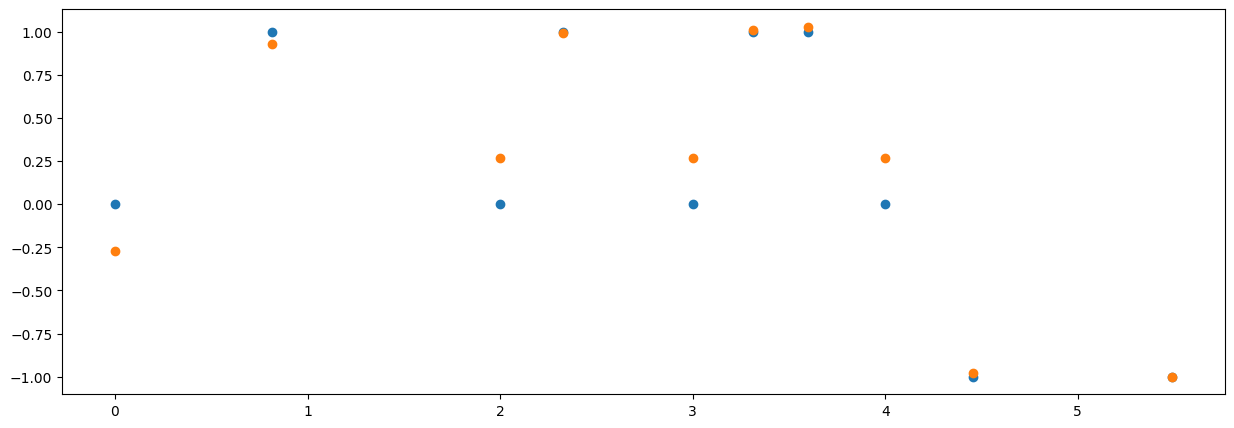

In [35]:
plt.figure(figsize=(15, 5))
plt.scatter(eigenvals, U.T @ f_g)
plt.scatter(eigenvals, f_g_cheb_tilde[:, -1])

In [36]:
errors_g_response

array([0.73992442, 0.71620159, 0.71887769, 0.70721871, 0.71582978,
       0.7476609 , 0.74460165, 0.7238682 , 0.73191329, 0.73600564])